[Trains two recurrent neural networks based upon a story and a question.](https://keras.io/examples/babi_rnn/)

In [1]:
import re, tarfile, tempfile
from functools import reduce

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Input, concatenate, Dense
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
RNN = LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 20
print(f"RNN = {RNN}\n"
      f"Embed = {EMBED_HIDDEN_SIZE}\n"
      f"Sent = {SENT_HIDDEN_SIZE}\n"
      f"Query = {QUERY_HIDDEN_SIZE}")

RNN = <class 'tensorflow.python.keras.layers.recurrent_v2.LSTM'>
Embed = 50
Sent = 100
Query = 100


In [4]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz',
                    origin='https://s3.amazonaws.com/text-datasets/'
                           'babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2'
          '.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

In [5]:
# Default QA1 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa1_single-supporting-fact_{}.txt'
# QA1 with 10,000 samples
# challenge = 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt'
# QA2 with 1000 samples
# challenge = 'tasks_1-20_v1-2/en/qa2_two-supporting-facts_{}.txt'
# QA2 with 10,000 samples
challenge = 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt'

In [6]:
with tarfile.open(path) as tar:
    raw = tar.extractfile(challenge.format('train'))
    for i,line in enumerate(raw.readlines()):
        print(line)
        if i == 10: break

b'1 Mary moved to the bathroom.\n'
b'2 Sandra journeyed to the bedroom.\n'
b'3 Mary got the football there.\n'
b'4 John went to the kitchen.\n'
b'5 Mary went back to the kitchen.\n'
b'6 Mary went back to the garden.\n'
b'7 Where is the football? \tgarden\t3 6\n'
b'8 Sandra went back to the office.\n'
b'9 John moved to the office.\n'
b'10 Sandra journeyed to the hallway.\n'
b'11 Daniel went back to the kitchen.\n'


In [7]:
def tokenize(sent):
    return [x.strip() for x in re.split(r'(\W+)', sent) if x.strip()]

In [8]:
tokenize('Bob dropped the apple. Where is the apple?')

['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']

In [9]:
def parse_stories(lines, only_supporting=False):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            if only_supporting:
                supporting = map(int, supporting.split())
                substory = [story[i-1] for i in supporting]
            else:
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data

def get_stories(f, only_supporting=False, max_length=None):
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) 
            for story, q, answer in data
            if not max_length or len(flatten(story)) < max_length]
    return data

In [10]:
with tarfile.open(path) as tar:
    train = get_stories(tar.extractfile(challenge.format('train')))
    test = get_stories(tar.extractfile(challenge.format('test')))

In [11]:
train[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.',
  'Mary',
  'got',
  'the',
  'football',
  'there',
  '.',
  'John',
  'went',
  'to',
  'the',
  'kitchen',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'kitchen',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'garden',
  '.'],
 ['Where', 'is', 'the', 'football', '?'],
 'garden')

In [12]:
vocab = set()
for story, q, answer in train + test:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

In [13]:
vocab_size = len(vocab) + 1
word_idx = {c: i for i,c in enumerate(vocab,1)}
story_maxlen = max(map(len, (x for x, _, _ in train + test)))
query_maxlen = max(map(len, (x for _, x, _ in train + test)))

In [14]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

In [15]:
x, xq, y = vectorize_stories(train, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(test, word_idx, story_maxlen, query_maxlen)

In [16]:
print(f"vocab = {vocab}")
print(f"x.shape = {x.shape}")
print(f"xq.shape = {xq.shape}")
print(f"y.shape = {y.shape}")
print(f"story_maxlen, query_maxlen = {story_maxlen}, {query_maxlen}")

vocab = ['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'is', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went']
x.shape = (10000, 552)
xq.shape = (10000, 5)
y.shape = (10000, 36)
story_maxlen, query_maxlen = 552, 5


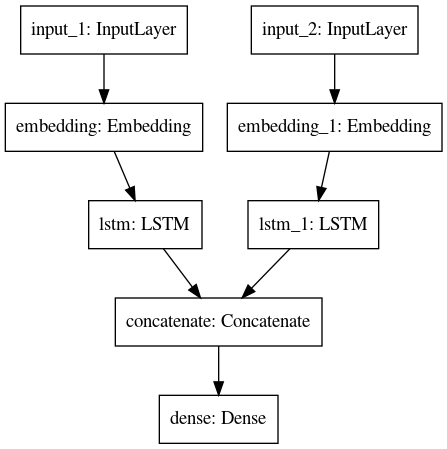

In [17]:
sentence = Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = Embedding(vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence = RNN(SENT_HIDDEN_SIZE)(encoded_sentence)

question = Input(shape=(query_maxlen,), dtype='int32')
encoded_question = Embedding(vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question = RNN(QUERY_HIDDEN_SIZE)(encoded_question)

merged = concatenate([encoded_sentence, encoded_question])
preds = Dense(vocab_size, activation='softmax')(merged)

model = Model([sentence, question], preds)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

plot_model(model, to_file='/tmp/model.png')

In [18]:
history = model.fit([x, xq], y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.05)

Train on 9500 samples, validate on 500 samples
Epoch 1/20
9500/9500 [==============================] - 17s 2ms/sample - loss: 1.8859 - accuracy: 0.1720 - val_loss: 1.7705 - val_accuracy: 0.2260
Epoch 2/20
9500/9500 [==============================] - 12s 1ms/sample - loss: 1.8024 - accuracy: 0.1685 - val_loss: 1.7957 - val_accuracy: 0.1760
Epoch 3/20
9500/9500 [==============================] - 12s 1ms/sample - loss: 1.7982 - accuracy: 0.1778 - val_loss: 1.7710 - val_accuracy: 0.2200
Epoch 4/20
9500/9500 [==============================] - 12s 1ms/sample - loss: 1.7530 - accuracy: 0.2512 - val_loss: 1.6279 - val_accuracy: 0.3880
Epoch 5/20
9500/9500 [==============================] - 12s 1ms/sample - loss: 1.5857 - accuracy: 0.3694 - val_loss: 1.5152 - val_accuracy: 0.3780
Epoch 6/20
9500/9500 [==============================] - 12s 1ms/sample - loss: 1.4906 - accuracy: 0.3905 - val_loss: 1.4680 - val_accuracy: 0.3920
Epoch 7/20
9500/9500 [==============================] - 12s 1ms/sample 

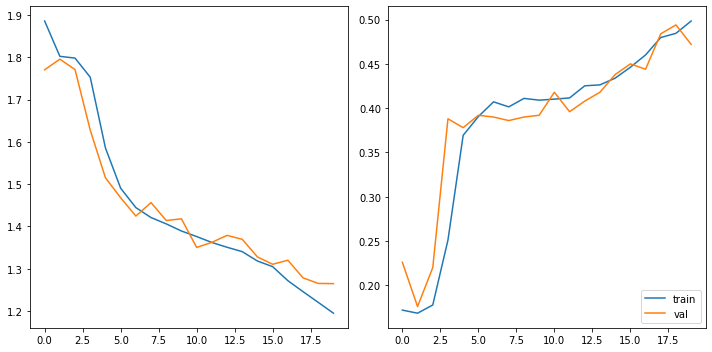

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['accuracy'], label='train')
plt.plot(history.epoch, history.history['val_accuracy'], label='val')
plt.legend(loc=4)
plt.tight_layout()

In [20]:
model.evaluate([tx, txq], ty,
               batch_size=BATCH_SIZE, verbose=0)

[1.3608667602539062, 0.396]